In [16]:
import pandas as pd
import dask.dataframe as dd
from dask.multiprocessing import get

import itertools
pd.set_option('display.max_rows', 700)
pd.set_option('display.max_columns', 600)

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, svm, tree
from sklearn.ensemble import RandomForestRegressor
from  sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
sns.set(rc={'figure.figsize':(16,9)})
#import swifter

np.random.seed(1907)

In [17]:
def initial_data_preparation():
    

    data = pd.read_csv("../data/interim/spark_processed_data.csv", sep="|")

    
    
    print(f"{len(data)} Rows.")
   

    multi_choice_columns = pd.read_csv("../data/interim/spark_multi_choice_columns.csv", sep="|")["0"].tolist()
    print("Multi_choice", multi_choice_columns)
    data = data.drop(multi_choice_columns, axis=1)
    
    # Preserve country columns for target transformation
    data["Country_for_target_transformation"] = data["Country"]
    
    
    # One hot encoding
    cat_columns = ["Country", "Gender", "JobSat", 
                                        "JobSeek",
                                        "Employment",
                                        "MainBranch", 
                                        "Hobbyist", 
                                        "EdLevel", 
                                        "NEWDevOps", 
                                        "NEWDevOpsImpt", 
                                        "NEWEdImpt", 
                                        "NEWLearn",
                                        "NEWOffTopic",
                                        "NEWOnboardGood",
                                        "NEWOtherComms",
                                        "NEWOvertime",
                                        "NEWPurpleLink","OpSys","OrgSize",
                                        "PurchaseWhat","SOAccount",
                                        "SOComm","SOPartFreq","SOVisitFreq",
                                        "SurveyEase", "SurveyLength","Trans", "UndergradMajor","WelcomeChange"]
    
    cat_columns = [col for col in cat_columns if col not in multi_choice_columns]
    print("Category Columns:",cat_columns)
    #data = pd.get_dummies(data=data, columns=cat_columns)

    
    data = data.dropna(subset=["ConvertedComp"], axis=0)
    data = data[data["ConvertedComp"] >0]
    
    #Drop countries that has less than 200 observation
    countries = data["Country_for_target_transformation"].value_counts()
    countries_to_drop = countries[countries <= 200].index.tolist()
    data = data[~data["Country_for_target_transformation"].isin(countries_to_drop)].reset_index(drop=True)
    
    #Drop observations have less then $100 ConvertedComp and professional dev.
    data = data[(~(data["ConvertedComp"]<100) &  (data.MainBranch == "I am a developer by profession"))]
    print(f"{len(data)} Rows.")
    
    
    # Fill NaNs with median
    nas = data.isna().sum()
    nas = nas[nas > 0]
    
    avg_prf_comp_by_country = data[data.MainBranch == "I am a developer by profession"].groupby("Country_for_target_transformation").ConvertedComp.median()
    target_transformer = lambda row: (row['ConvertedComp'] / avg_prf_comp_by_country[row["Country_for_target_transformation"]]) *100
    
    data["ConvertedComp_index"] = data.apply(target_transformer, axis=1)

    #LABEL :"ConvertedComp"
    return data, multi_choice_columns, cat_columns

In [18]:
data, multi_choice_columns, cat_columns = initial_data_preparation()

64461 Rows.
Multi_choice ['DatabaseDesireNextYear', 'DatabaseWorkedWith', 'DevType', 'Ethnicity', 'Gender', 'JobFactors', 'LanguageDesireNextYear', 'LanguageWorkedWith', 'MiscTechDesireNextYear', 'MiscTechWorkedWith', 'NEWCollabToolsDesireNextYear', 'NEWCollabToolsWorkedWith', 'NEWJobHunt', 'NEWJobHuntResearch', 'NEWPurchaseResearch', 'NEWSOSites', 'NEWStuck', 'PlatformDesireNextYear', 'PlatformWorkedWith', 'Sexuality', 'WebframeDesireNextYear', 'WebframeWorkedWith']
Category Columns: ['Country', 'JobSat', 'JobSeek', 'Employment', 'MainBranch', 'Hobbyist', 'EdLevel', 'NEWDevOps', 'NEWDevOpsImpt', 'NEWEdImpt', 'NEWLearn', 'NEWOffTopic', 'NEWOnboardGood', 'NEWOtherComms', 'NEWOvertime', 'NEWPurpleLink', 'OpSys', 'OrgSize', 'PurchaseWhat', 'SOAccount', 'SOComm', 'SOPartFreq', 'SOVisitFreq', 'SurveyEase', 'SurveyLength', 'Trans', 'UndergradMajor', 'WelcomeChange']
27366 Rows.


In [19]:
data.head()

,MainBranch,Hobbyist,Age,Age1stCode,ConvertedComp,Country,EdLevel,Employment,JobSat,JobSeek,NEWDevOps,NEWDevOpsImpt,NEWEdImpt,NEWLearn,NEWOffTopic,NEWOnboardGood,NEWOtherComms,NEWOvertime,NEWPurpleLink,OpSys,OrgSize,PurchaseWhat,SOAccount,SOComm,SOPartFreq,SOVisitFreq,SurveyEase,SurveyLength,Trans,UndergradMajor,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro,DatabaseDesireNextYear_MariaDB,DatabaseDesireNextYear_Microsoft SQL Server,DatabaseDesireNextYear_MongoDB,DatabaseDesireNextYear_MySQL,DatabaseDesireNextYear_Oracle,DatabaseDesireNextYear_PostgreSQL,DatabaseDesireNextYear_Redis,DatabaseDesireNextYear_SQLite,DatabaseDesireNextYear_Cassandra,DatabaseDesireNextYear_IBM DB2,DatabaseDesireNextYear_DynamoDB,DatabaseDesireNextYear_Elasticsearch,DatabaseDesireNextYear_Firebase,DatabaseDesireNextYear_Couchbase,DatabaseWorkedWith_Couchbase,DatabaseWorkedWith_Microsoft SQL Server,DatabaseWorkedWith_MySQL,DatabaseWorkedWith_PostgreSQL,DatabaseWorkedWith_DynamoDB,DatabaseWorkedWith_Elasticsearch,DatabaseWorkedWith_Firebase,DatabaseWorkedWith_MariaDB,DatabaseWorkedWith_SQLite,DatabaseWorkedWith_MongoDB,DatabaseWorkedWith_Oracle,DatabaseWorkedWith_Redis,DatabaseWorkedWith_IBM DB2,DatabaseWorkedWith_Cassandra,DevType_Scientist,"DevType_Developer, back-end","DevType_Developer, desktop or enterprise applications","DevType_Developer, front-end","DevType_Developer, full-stack","DevType_Developer, game or graphics","DevType_Developer, mobile",DevType_Academic researcher,DevType_Database administrator,DevType_Designer,"DevType_Developer, QA or test","DevType_Engineer, data",DevType_Data or business analyst,DevType_Product manager,DevType_Data scientist or machine learning specialist,"DevType_Developer, embedded applications or devices",DevType_DevOps specialist,DevType_System administrator,DevType_Senior executive/VP,"DevType_Engineer, site reliability",DevType_Engineering manager,DevType_Educator,DevType_Marketing or sales professional,Ethnicity_White or of European descent,Ethnicity_South Asian,Ethnicity_East Asian,Ethnicity_Biracial,Ethnicity_Multiracial,Ethnicity_Black or of African descent,Ethnicity_Southeast Asian,Ethnicity_Middle Eastern,"Ethnicity_Indigenous (such as Native American, Pacific Islander, or Indigenous Australian)",Ethnicity_Hispanic or Latino/a/x,Gender_Man,"Gender_Non-binary, genderqueer, or gender non-conforming",Gender_Woman,JobFactors_Industry that I’d be working in,"JobFactors_Languages, frameworks, and other technologies I’d be working with",JobFactors_How widely used or impactful my work output would be,JobFactors_Office environment or company culture,JobFactors_Opportunities for professional development,JobFactors_Remote work options,JobFactors_Diversity of the company or organization,JobFactors_Specific department or team I’d be working on,JobFactors_Financial performance or funding status of the company or organization,JobFactors_Family friendliness,JobFactors_Flex time or a flexible schedule,LanguageDesireNextYear_C#,LanguageDesireNextYear_Bash/Shell/PowerShell,LanguageDesireNextYear_JavaScript,LanguageDesireNextYear_Python,LanguageDesireNextYear_R,LanguageDesireNextYear_SQL,LanguageDesireNextYear_C,LanguageDesireNextYear_C++,LanguageDesireNextYear_Dart,LanguageDesireNextYear_HTML/CSS,LanguageDesireNextYear_Java,LanguageDesireNextYear_Kotlin,LanguageDesireNextYear_Objective-C,LanguageDesireNextYear_Perl,LanguageDesireNextYear_Swift,LanguageDesireNextYear_TypeScript,LanguageDesireNextYear_PHP,LanguageDesireNextYear_Haskell,LanguageDesireNextYear_Go,LanguageDesireNextYear_Rust,LanguageDesireNextYear_Julia,LanguageDesireNextYear_VBA,LanguageDesireNextYear_Ruby,LanguageDesireNextYear_Scala,LanguageDesireNextYear_Assembly,LanguageWorkedWith_Assembly,LanguageWorkedWith_Bash/Shell/PowerShell,LanguageWorkedWith_C,LanguageWorkedWith_C#,LanguageWorkedWith_C++,LanguageWorkedWith_HTML/CSS,LanguageWorkedWith_JavaScript,LanguageWorkedWith_PHP,LanguageWorkedWith_Python,LanguageWorkedWith_SQL,LanguageWorkedWith_TypeScript,Lan

### Professional Developer Compantsations by Country

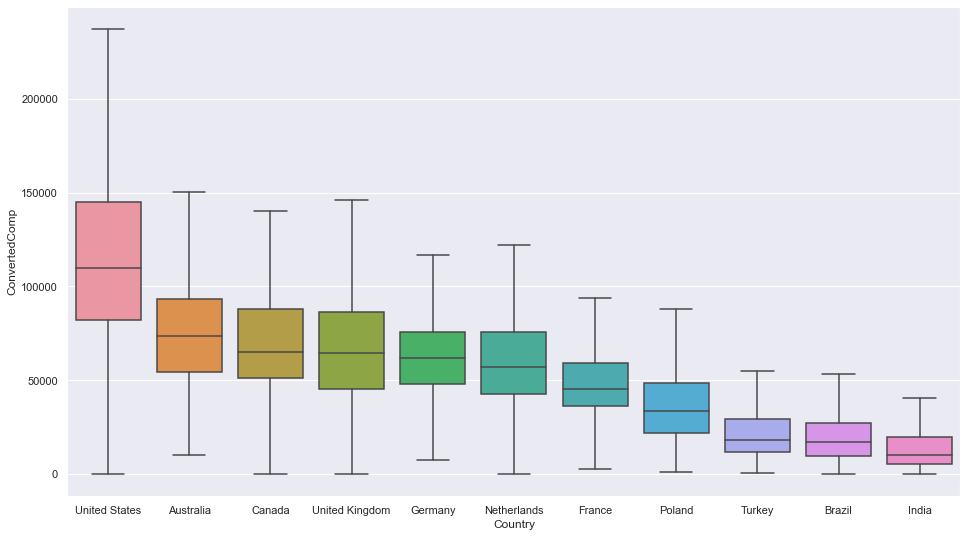

In [20]:
top_countries_list = data.Country.value_counts().head(10).index.tolist() + ["Turkey"]
top_countries = data[data.Country.isin(top_countries_list) 
                     & (data.MainBranch == "I am a developer by profession")
                   &  (data.ConvertedComp <= 300000)]

median_by_country = data.groupby("Country").ConvertedComp.median()
sorting = median_by_country[top_countries_list].sort_values(ascending=False).index.tolist()

ax = sns.boxplot(x="Country", y="ConvertedComp", data=top_countries,
                 showfliers = False, order=sorting)

### Professional Developer Compantsations by YearsCodePro

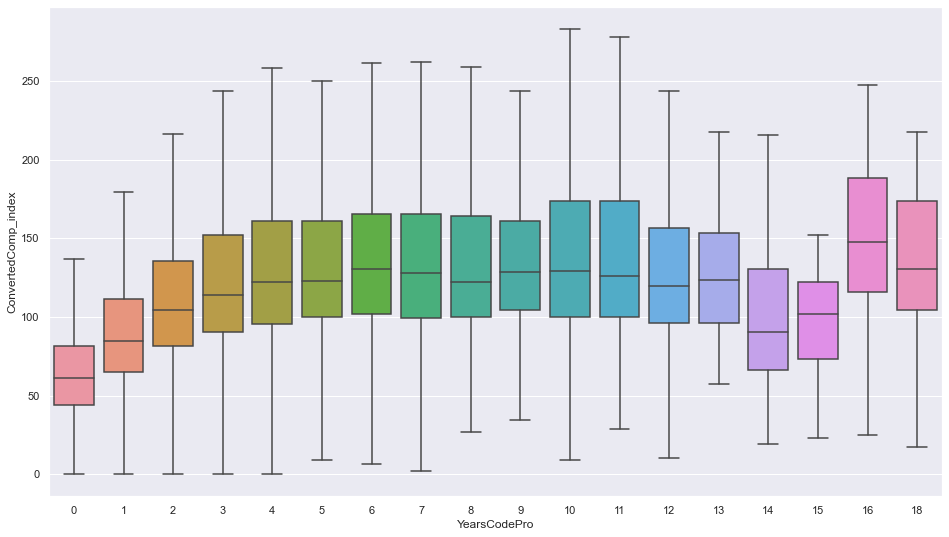

In [21]:
data_ = data[(data.MainBranch == "I am a developer by profession")
            &(data.ConvertedComp <= 300000)]
data_ = data_.dropna(subset=["YearsCodePro"])
data_.YearsCodePro = data_.YearsCodePro.apply(lambda x: int(x/3))
ax = sns.boxplot(x="YearsCodePro", y="ConvertedComp_index", data=data_,
                 showfliers = False)

### Professional Developer Compantsations by Education Level

Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          13368
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                        6980
Some college/university study without earning a degree                                 3195
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)     1157
Associate degree (A.A., A.S., etc.)                                                     963
Other doctoral degree (Ph.D., Ed.D., etc.)                                              718
Professional degree (JD, MD, etc.)                                                      324
I never completed any formal education                                                  114
Primary/elementary school                                                               107
Name: EdLevel, dtype: int64


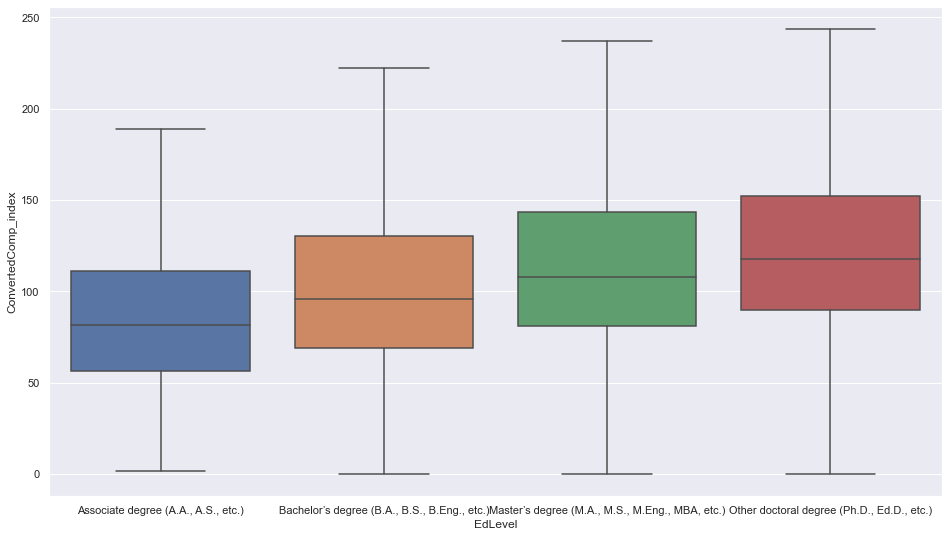

In [22]:
print(data.EdLevel.value_counts())

degrees = ['Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
            'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
            'Other doctoral degree (Ph.D., Ed.D., etc.)',
           "Associate degree (A.A., A.S., etc.)"
          ]

data_ =  data[data.EdLevel.isin(degrees) 
              & (data.MainBranch == "I am a developer by profession")
             &  (data.ConvertedComp <= 300000)]
data_ = data_.sort_values("EdLevel")
ax = sns.boxplot(x="EdLevel", y="ConvertedComp_index", data=data_,
                 showfliers = False)

### Job Satisfaction & Job Search

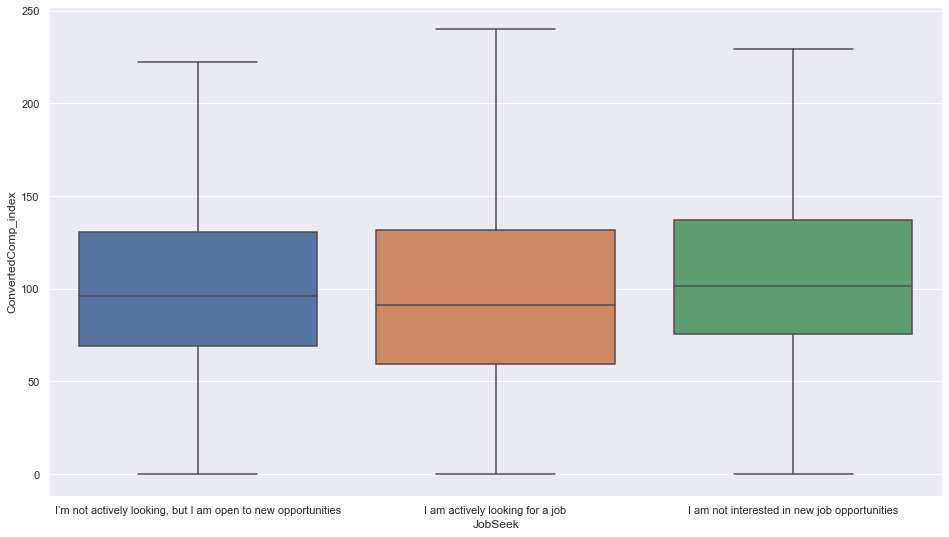

In [23]:
data_ =  data[(data.MainBranch == "I am a developer by profession")
             &  (data.ConvertedComp <= 300000)]

ax = sns.boxplot(x="JobSeek", y="ConvertedComp_index", data=data_,
                 showfliers = False)

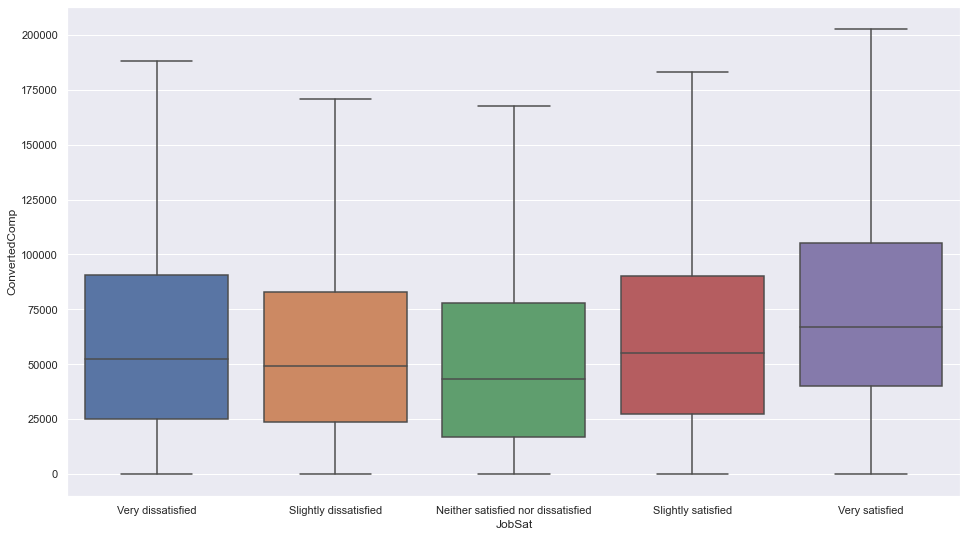

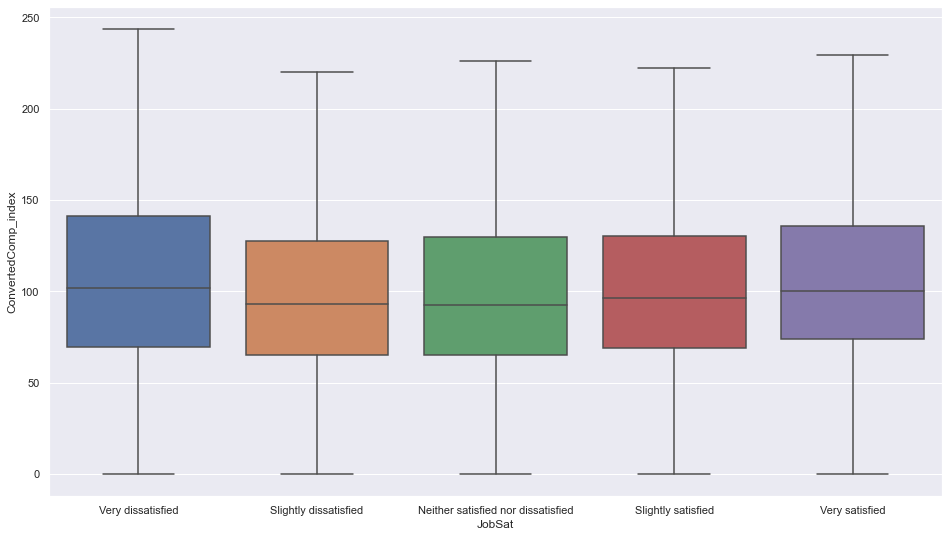

In [24]:
data_ =  data[(data.MainBranch == "I am a developer by profession")
             &  (data.ConvertedComp <= 300000)]

ax = sns.boxplot(x="JobSat", y="ConvertedComp", data=data_,
                 showfliers = False,
                order=['Very dissatisfied',
                     'Slightly dissatisfied',
                     'Neither satisfied nor dissatisfied',
                     'Slightly satisfied',
                     'Very satisfied'])
plt.show()
ax = sns.boxplot(x="JobSat", y="ConvertedComp_index", data=data_,
                 showfliers = False,
                order=['Very dissatisfied',
                     'Slightly dissatisfied',
                     'Neither satisfied nor dissatisfied',
                     'Slightly satisfied',
                     'Very satisfied'])
plt.show()

### By technologies WorkedWith

In [25]:
def calculate_high_and_low_leverage_tech(data):
    technologies = [feat for feat in data.columns if "WorkedWith" in feat]
    tech_leverages = {}
    for tech in technologies:
        tech_mean = data.groupby(tech).ConvertedComp_index.mean()
        if len(tech_mean) != 2: continue
        tech_leverage = (tech_mean.loc[1] / tech_mean.loc[0]) -1
        tech_leverages[tech] = tech_leverage
    tech_leverages = pd.Series(tech_leverages).sort_values(ascending=False)

    high_leverage_technologies = tech_leverages[tech_leverages >= tech_leverages.quantile(0.80)].index.tolist()
    low_leverage_technologies = tech_leverages[tech_leverages <= tech_leverages.quantile(0.20)].index.tolist()
    return high_leverage_technologies, low_leverage_technologies, tech_leverages
high_leverage_technologies, low_leverage_technologies, tech_leverages = calculate_high_and_low_leverage_tech(data)

In [26]:
tech_leverages

MiscTechWorkedWith_Chef                                    0.385494
LanguageWorkedWith_Scala                                   0.372603
MiscTechWorkedWith_Hadoop                                  0.334577
DatabaseWorkedWith_Cassandra                               0.320530
MiscTechWorkedWith_Apache Spark                            0.317669
LanguageWorkedWith_Perl                                    0.298168
LanguageWorkedWith_Objective-C                             0.259850
PlatformWorkedWith_IBM Cloud or Watson                     0.238979
DatabaseWorkedWith_DynamoDB                                0.213734
DatabaseWorkedWith_Couchbase                               0.193580
PlatformWorkedWith_AWS                                     0.174202
PlatformWorkedWith_Kubernetes                              0.171887
NEWCollabToolsWorkedWith_Stack Overflow for Teams          0.165616
LanguageWorkedWith_Go                                      0.161254
LanguageWorkedWith_Dart                         

In [27]:
high_leverage_technologies

['MiscTechWorkedWith_Chef',
 'LanguageWorkedWith_Scala',
 'MiscTechWorkedWith_Hadoop',
 'DatabaseWorkedWith_Cassandra',
 'MiscTechWorkedWith_Apache Spark',
 'LanguageWorkedWith_Perl',
 'LanguageWorkedWith_Objective-C',
 'PlatformWorkedWith_IBM Cloud or Watson',
 'DatabaseWorkedWith_DynamoDB',
 'DatabaseWorkedWith_Couchbase',
 'PlatformWorkedWith_AWS',
 'PlatformWorkedWith_Kubernetes',
 'NEWCollabToolsWorkedWith_Stack Overflow for Teams',
 'LanguageWorkedWith_Go',
 'LanguageWorkedWith_Dart',
 'PlatformWorkedWith_MacOS',
 'LanguageWorkedWith_Ruby',
 'DatabaseWorkedWith_Redis',
 'LanguageWorkedWith_Swift',
 'LanguageWorkedWith_Julia',
 'NEWCollabToolsWorkedWith_Jira']

In [28]:
low_leverage_technologies

['LanguageWorkedWith_C#',
 'NEWCollabToolsWorkedWith_Gitlab',
 'MiscTechWorkedWith_Cordova',
 'DatabaseWorkedWith_MySQL',
 'PlatformWorkedWith_WordPress',
 'LanguageWorkedWith_SQL',
 'PlatformWorkedWith_Arduino',
 'LanguageWorkedWith_Java',
 'WebframeWorkedWith_jQuery',
 'PlatformWorkedWith_Windows',
 'WebframeWorkedWith_Vue.js',
 'DatabaseWorkedWith_MariaDB',
 'MiscTechWorkedWith_Unreal Engine',
 'LanguageWorkedWith_JavaScript',
 'MiscTechWorkedWith_Unity 3D',
 'LanguageWorkedWith_C',
 'WebframeWorkedWith_Symfony',
 'LanguageWorkedWith_HTML/CSS',
 'LanguageWorkedWith_PHP',
 'LanguageWorkedWith_Haskell',
 'WebframeWorkedWith_Laravel']

Leverage +/-: 0.31


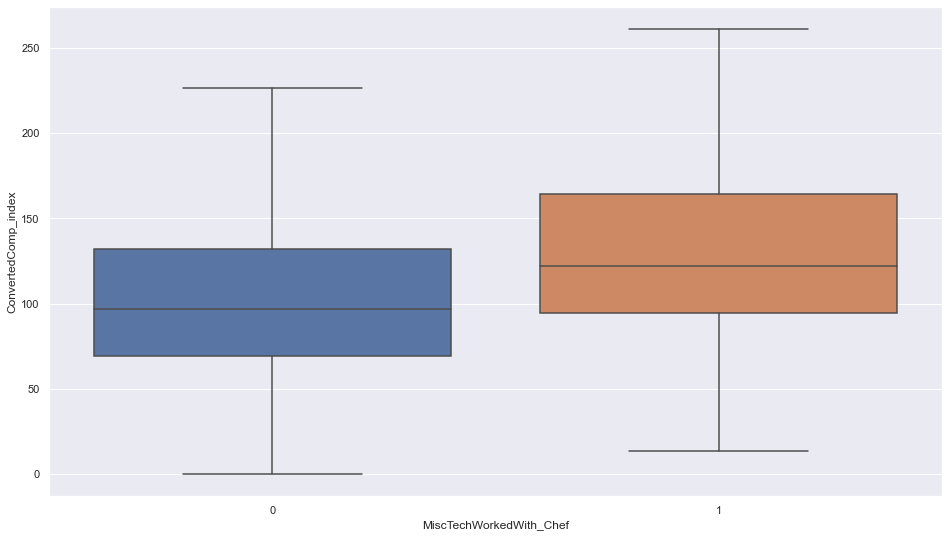

Leverage +/-: 0.24


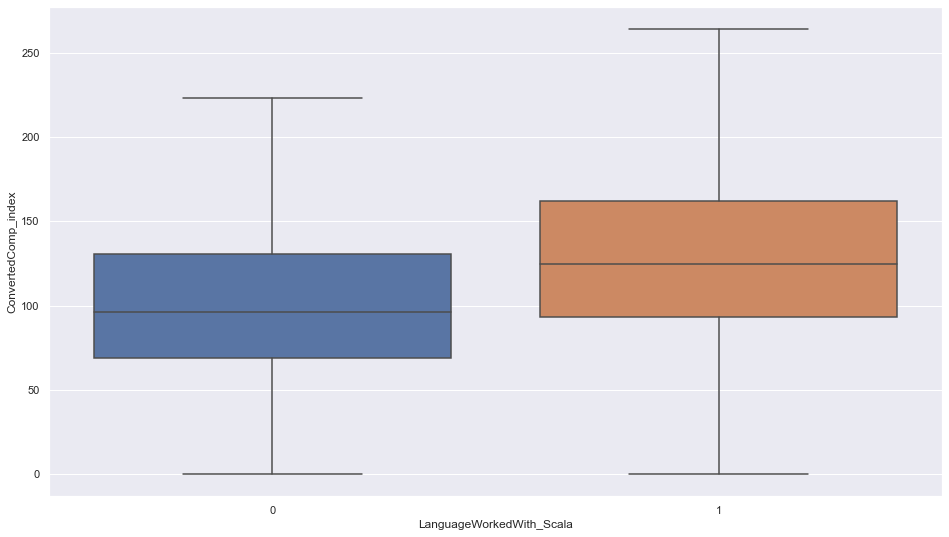

Leverage +/-: 0.23


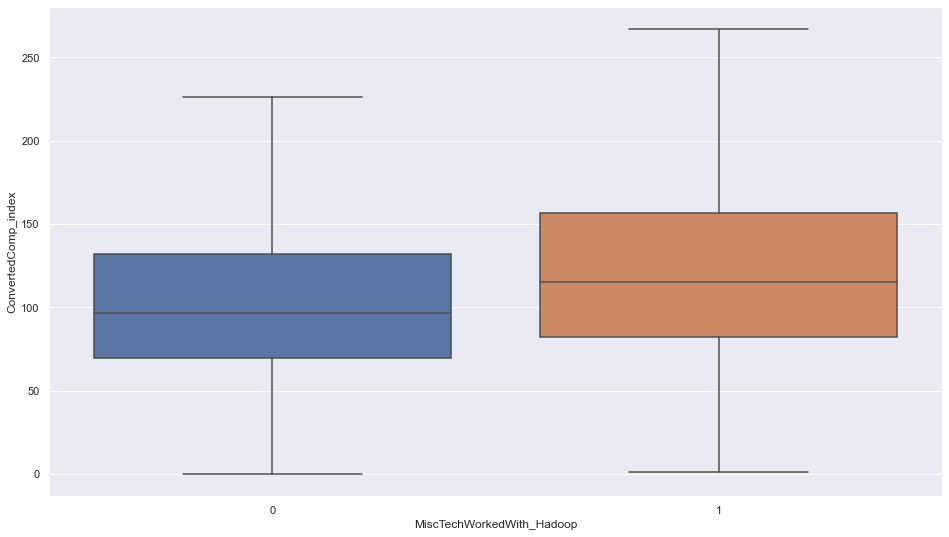

Leverage +/-: 0.32


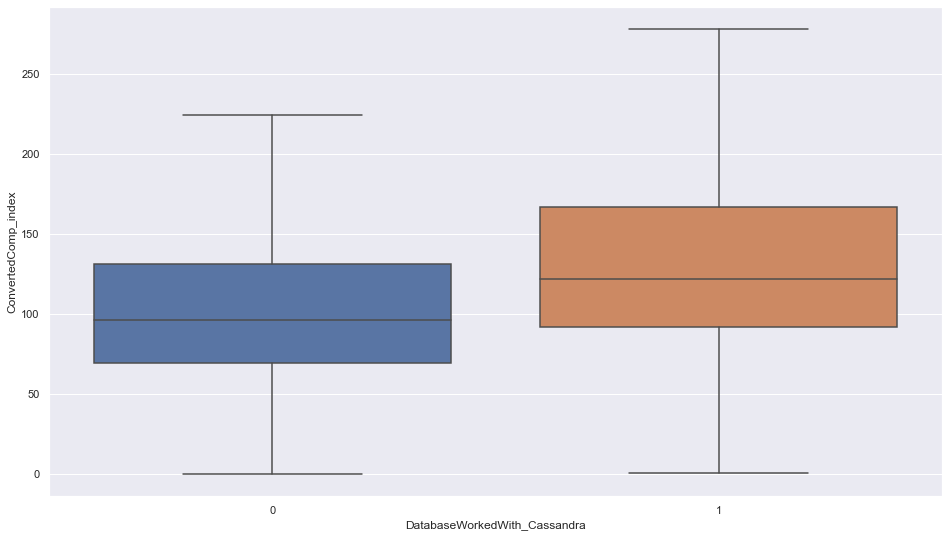

Leverage +/-: 0.21


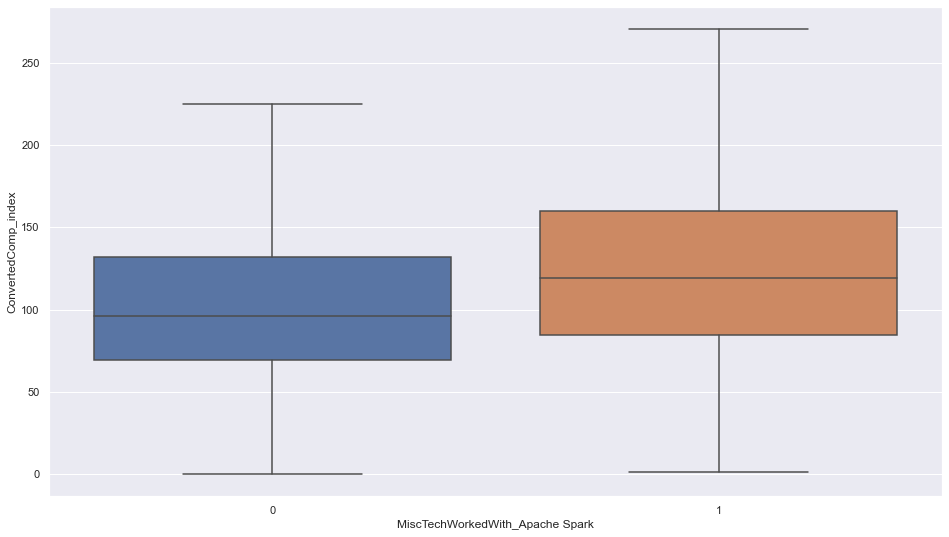

Leverage +/-: 0.19


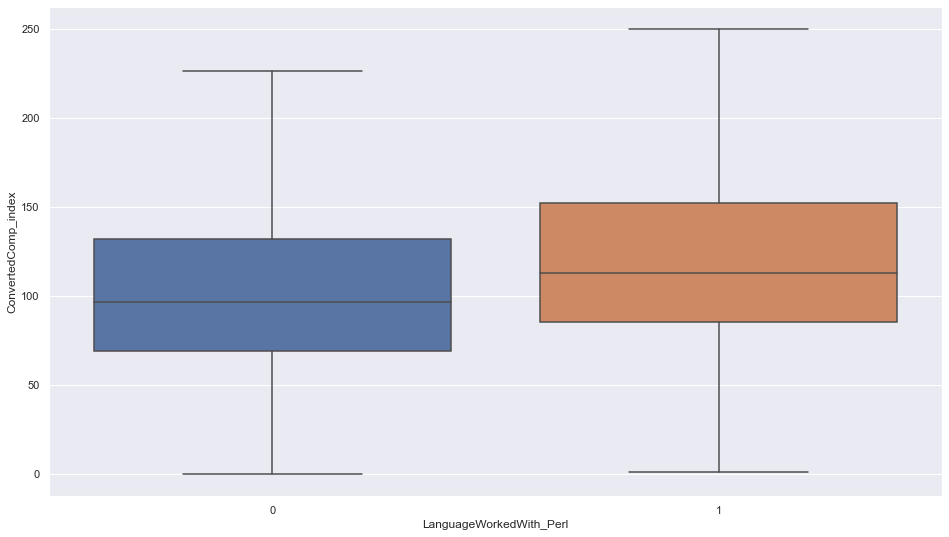

Leverage +/-: 0.12


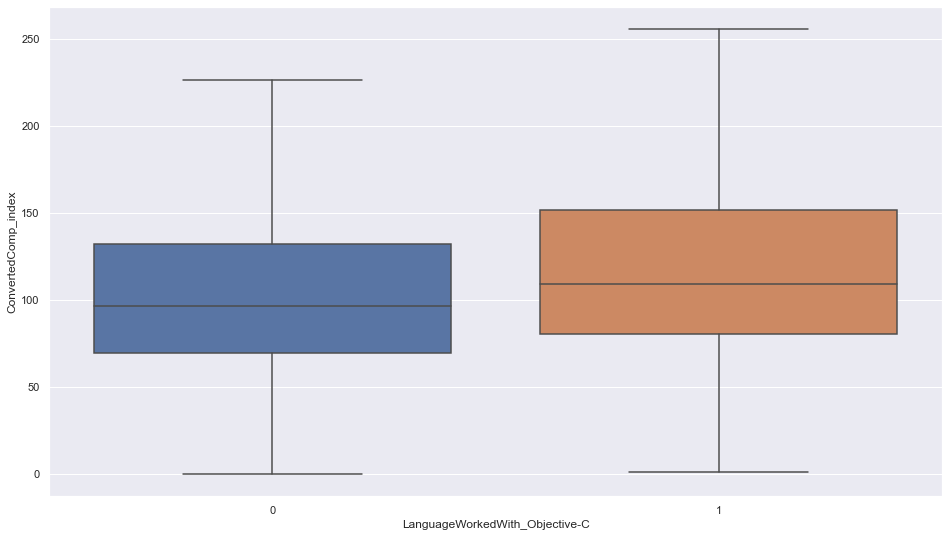

Leverage +/-: 0.12


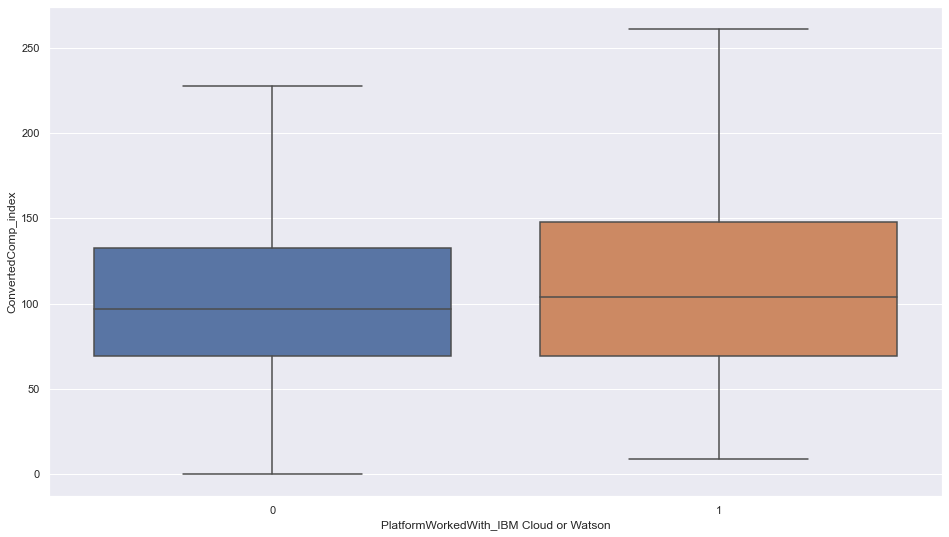

Leverage +/-: 0.19


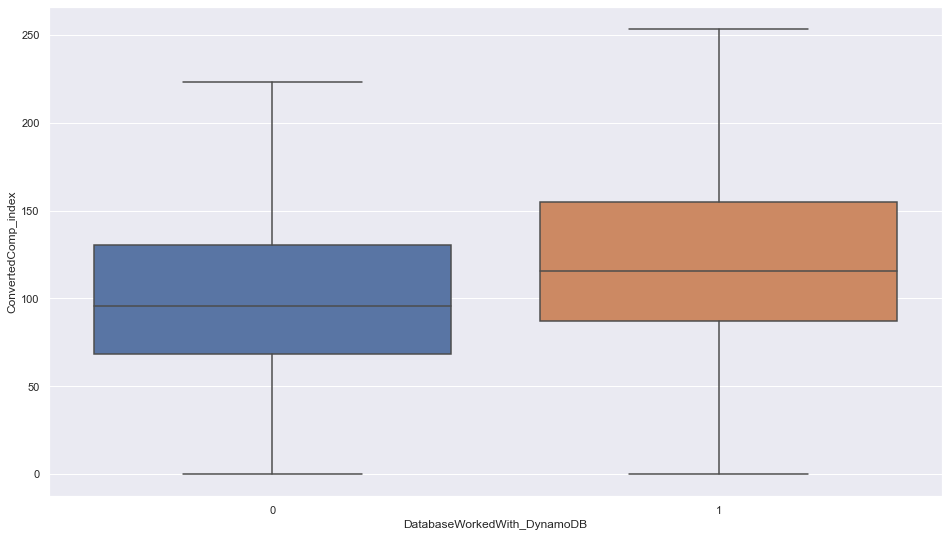

Leverage +/-: 0.21


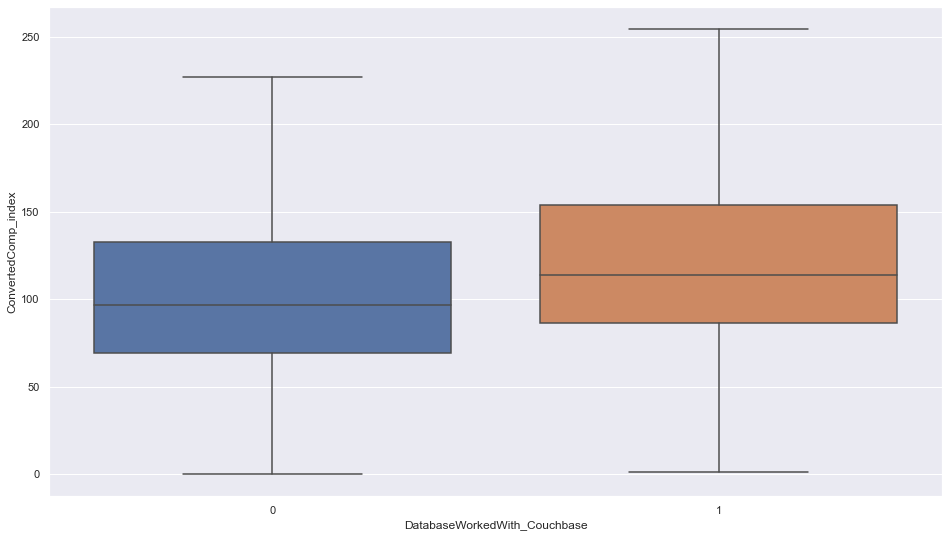

Leverage +/-: 0.17


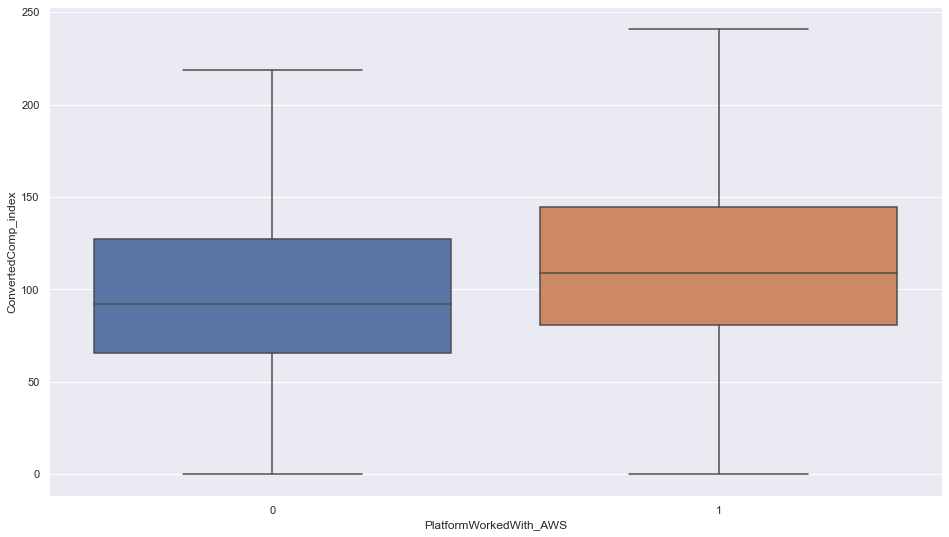

Leverage +/-: 0.19


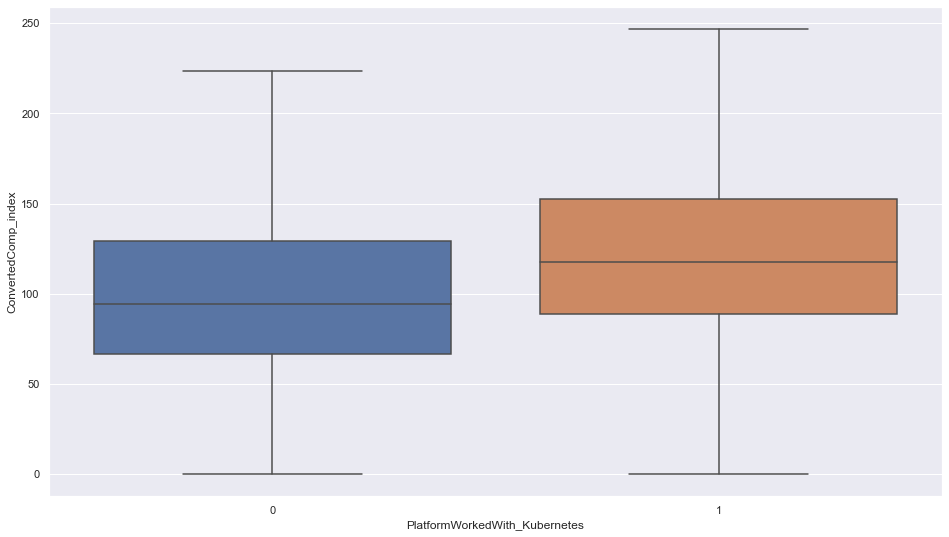

Leverage +/-: 0.08


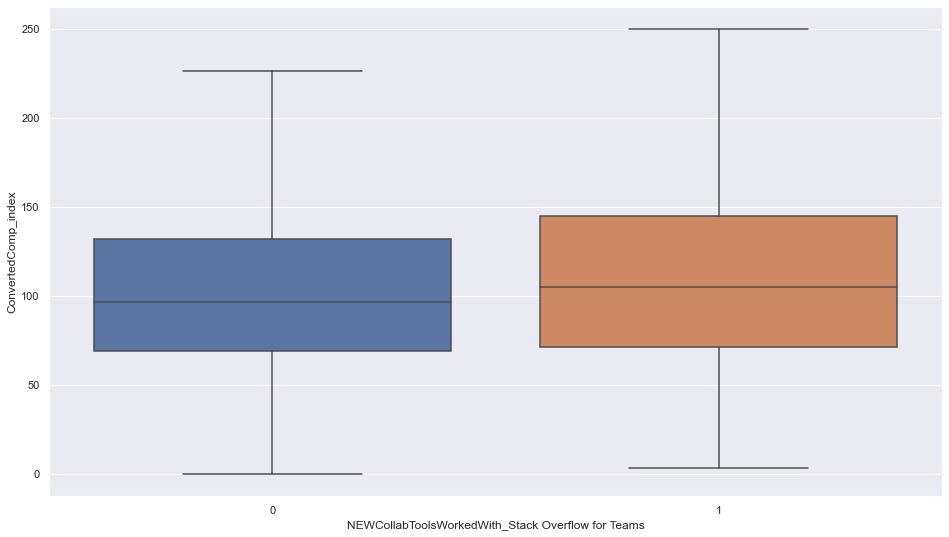

Leverage +/-: 0.19


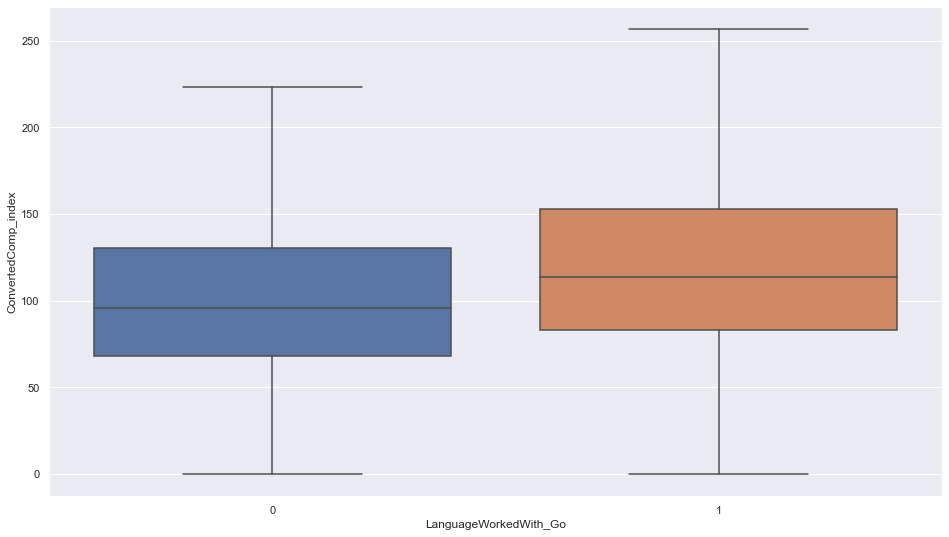

Leverage +/-: 0.02


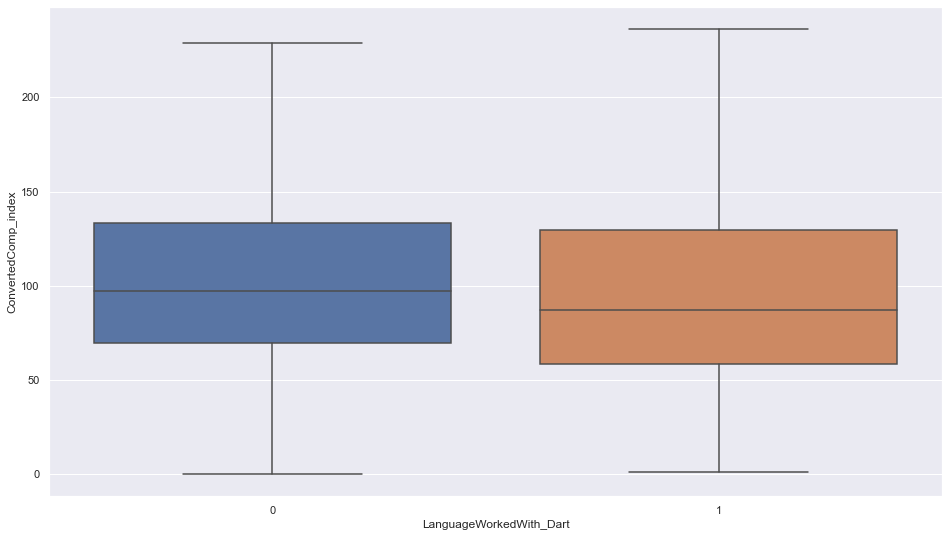

Leverage +/-: 0.11


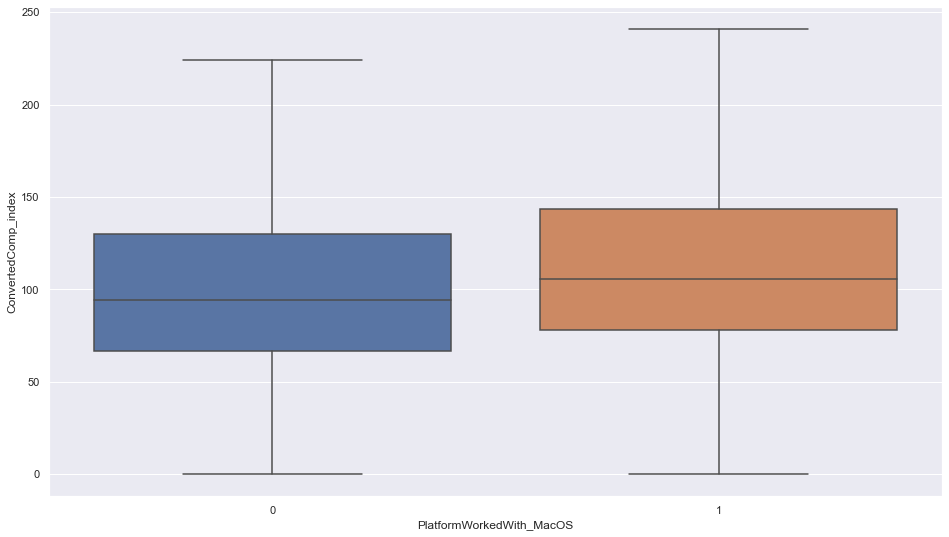

Leverage +/-: 0.08


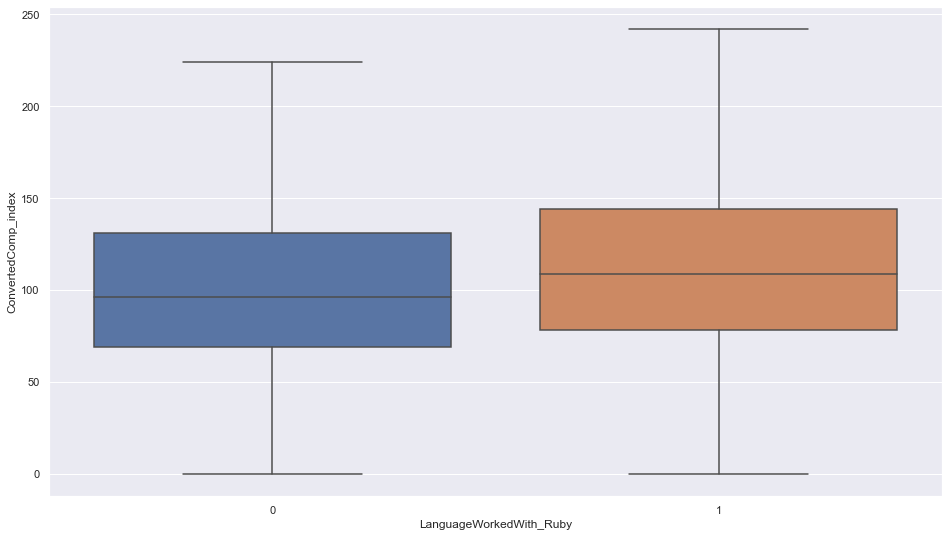

Leverage +/-: 0.2


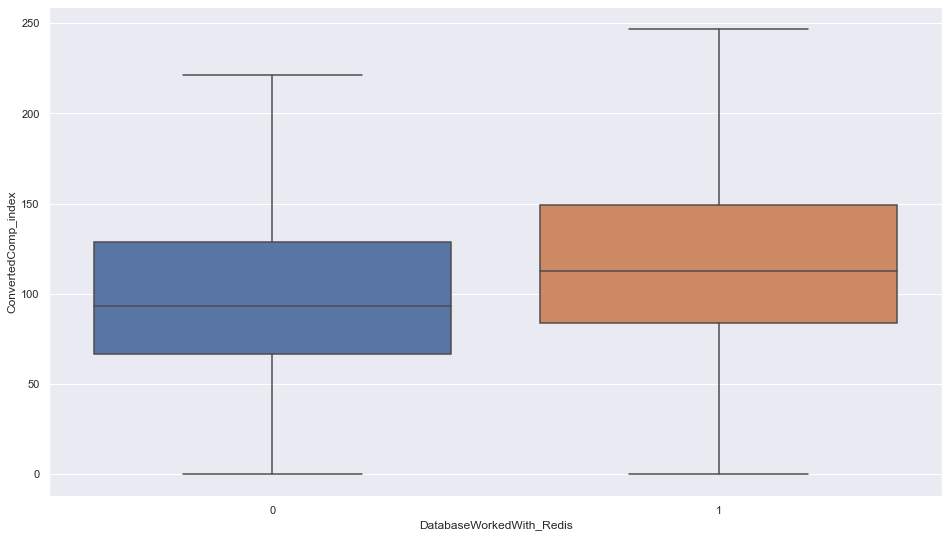

Leverage +/-: 0.05


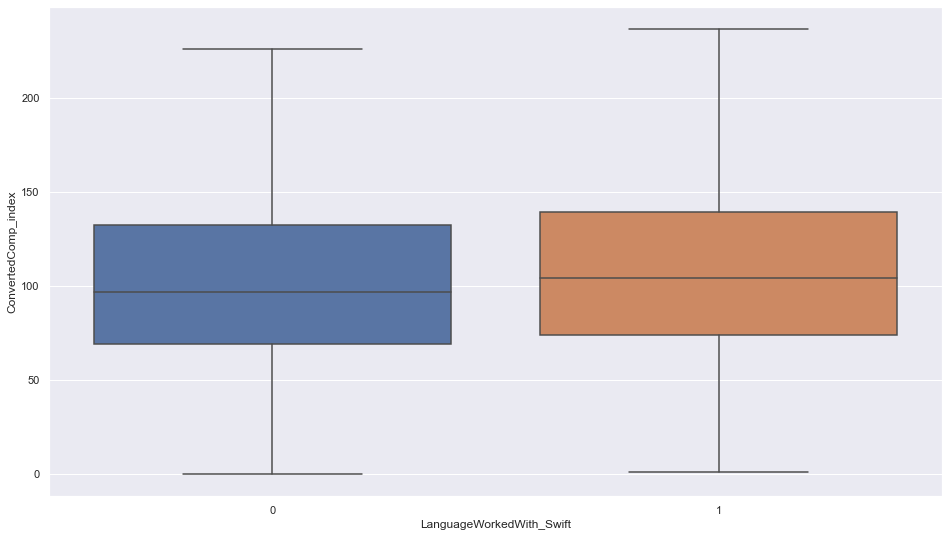

Leverage +/-: -0.01


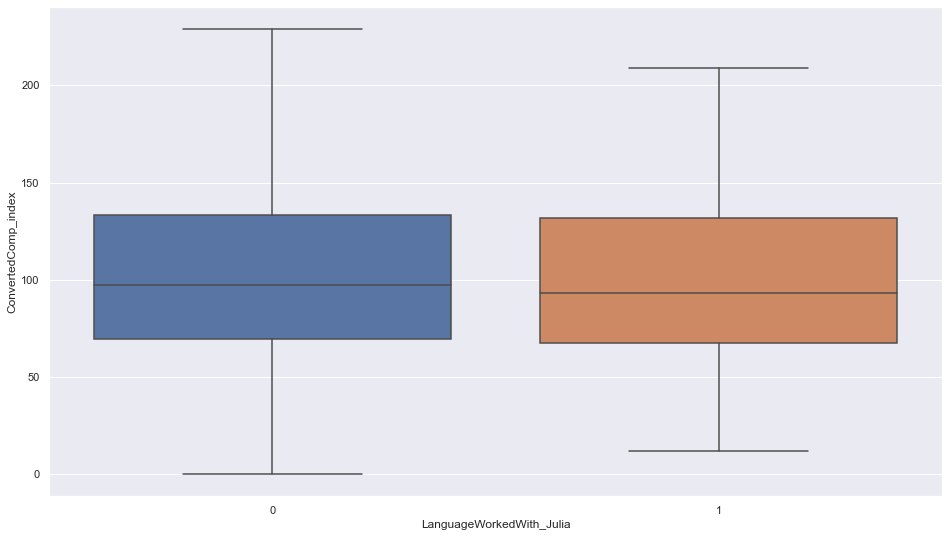

Leverage +/-: 0.19


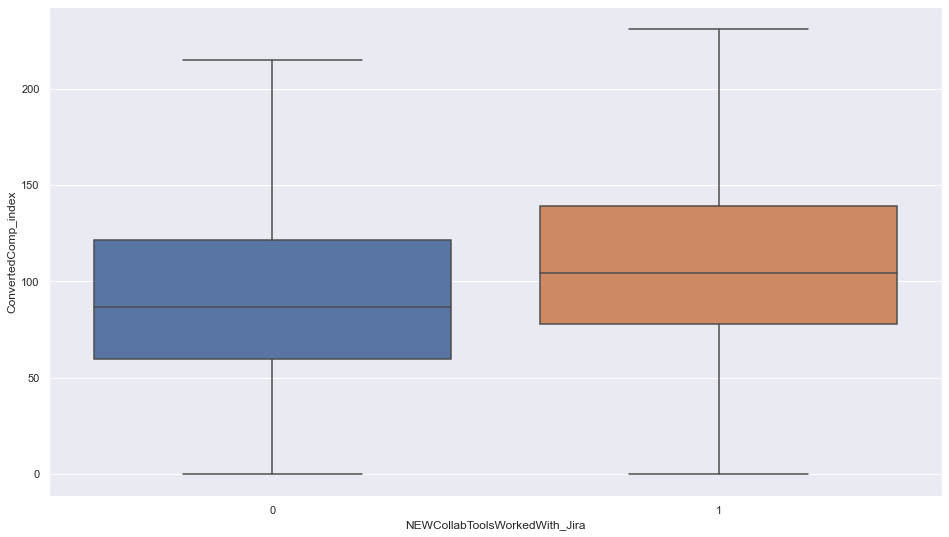

In [29]:
data_ =  data[(data.MainBranch == "I am a developer by profession")
             &  (data.ConvertedComp <= 300000)]

for col in high_leverage_technologies:
    ax = sns.boxplot(x=col, y="ConvertedComp_index", data=data_,
                     showfliers = False)
    
    medians = data_.groupby([col])['ConvertedComp_index'].mean()
    vertical_offset = data_['ConvertedComp_index'].mean() * 0.05 # offset from median for display
    print("Leverage +/-:", round(medians[1] / medians[0] -1,2))
    #for xtick in ax.get_xticks():
    #    ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
    #            horizontalalignment='center',size='x-small',color='w',weight='semibold')
    
    plt.show()

### By DevType

Leverage +/-: 0.03


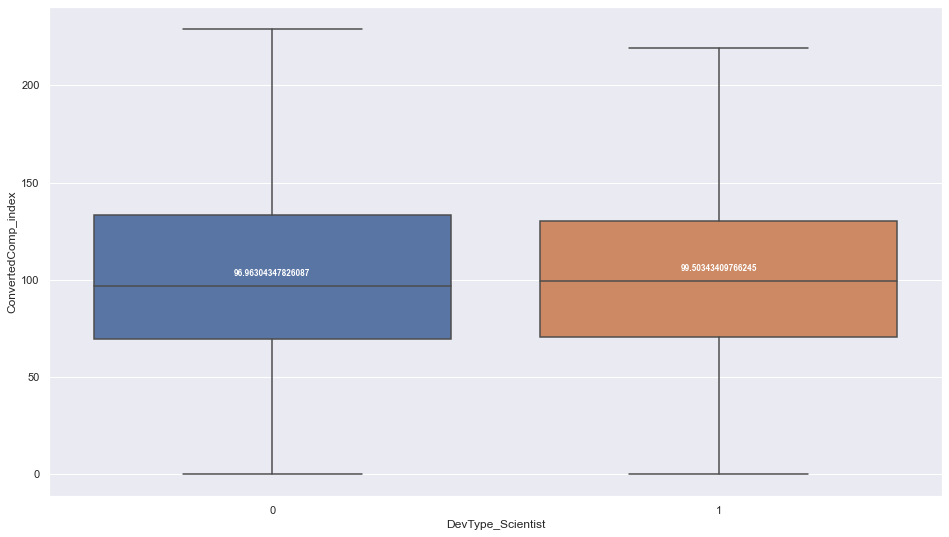

Leverage +/-: 0.06


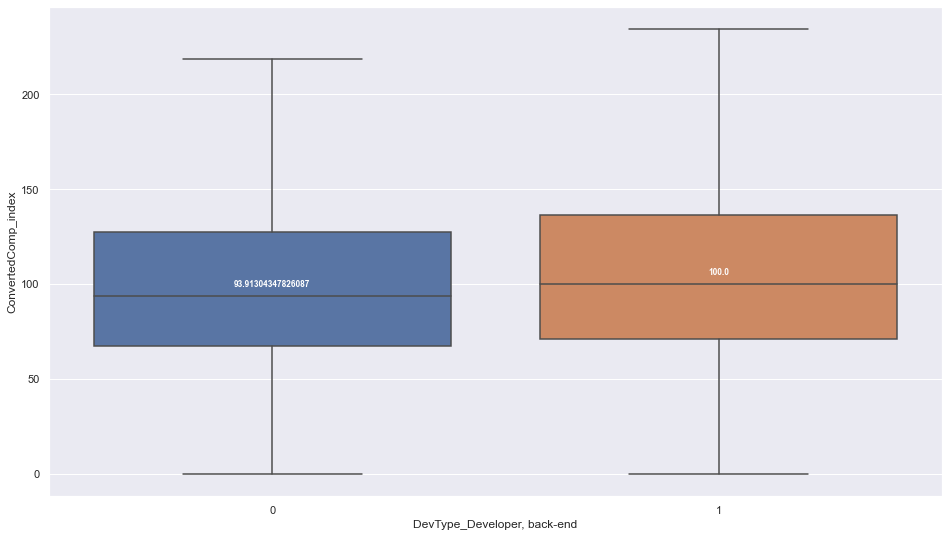

Leverage +/-: 0.04


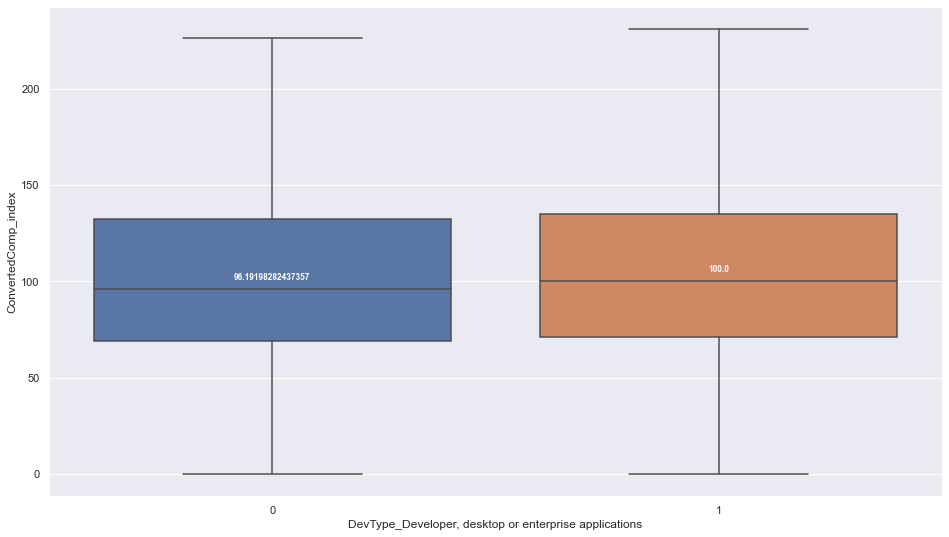

Leverage +/-: -0.09


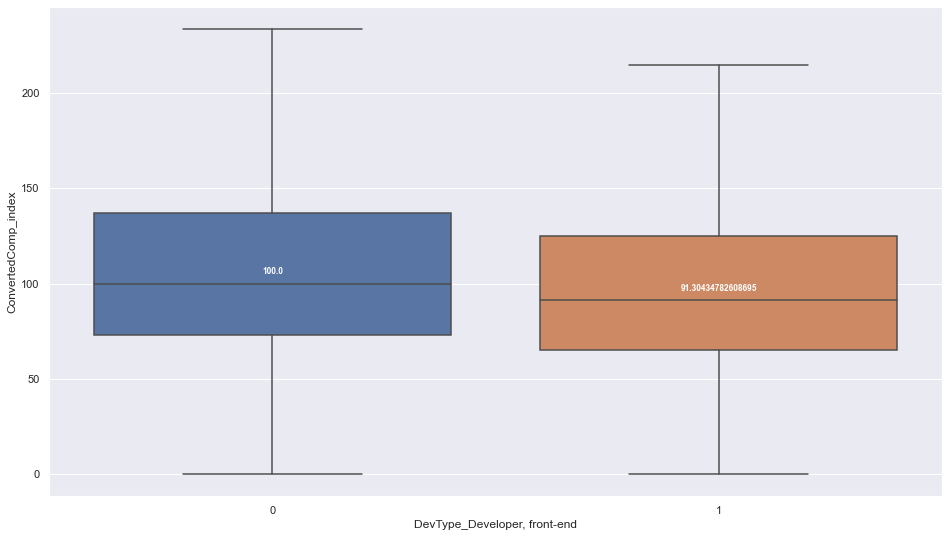

Leverage +/-: -0.03


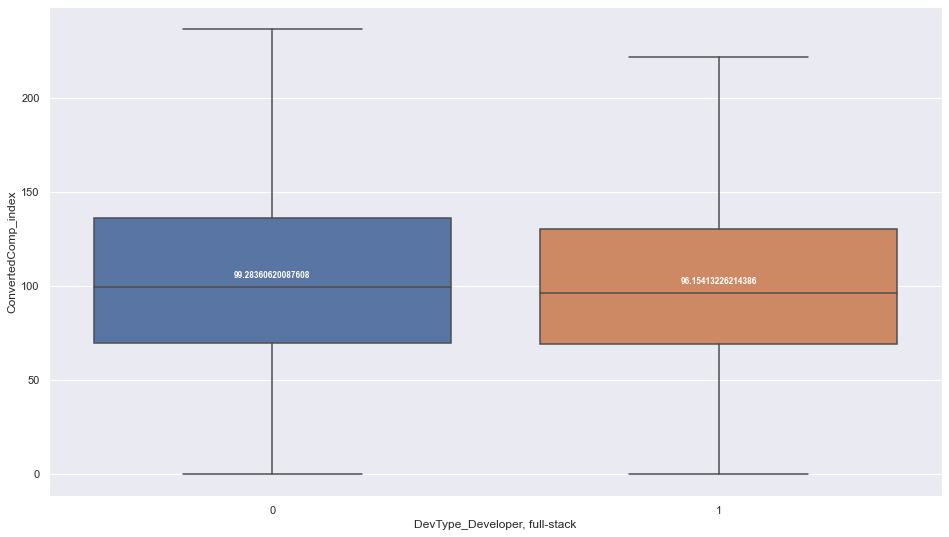

Leverage +/-: -0.06


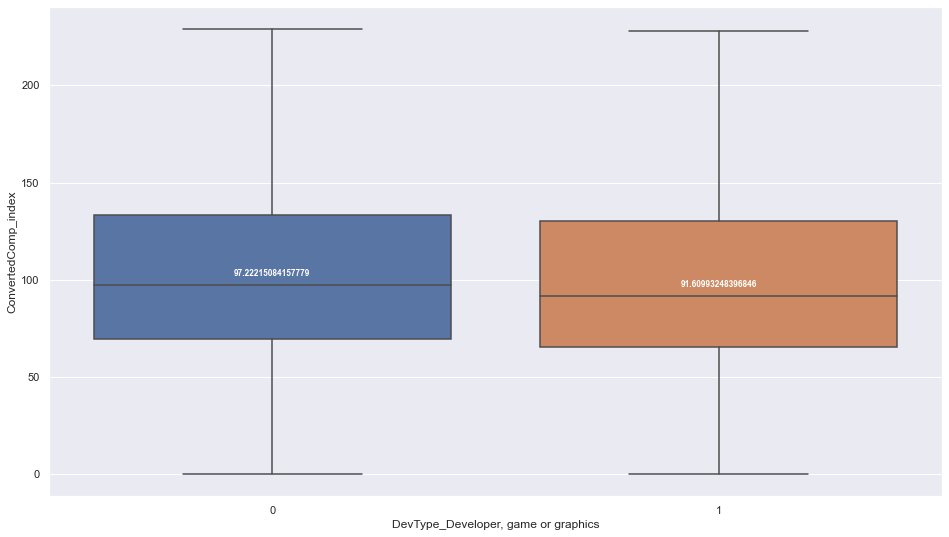

Leverage +/-: 0.0


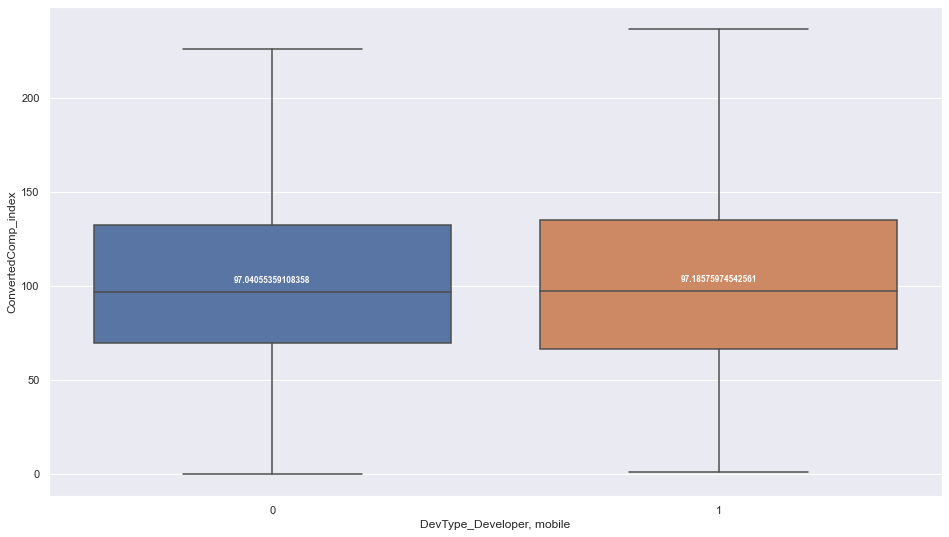

Leverage +/-: -0.09


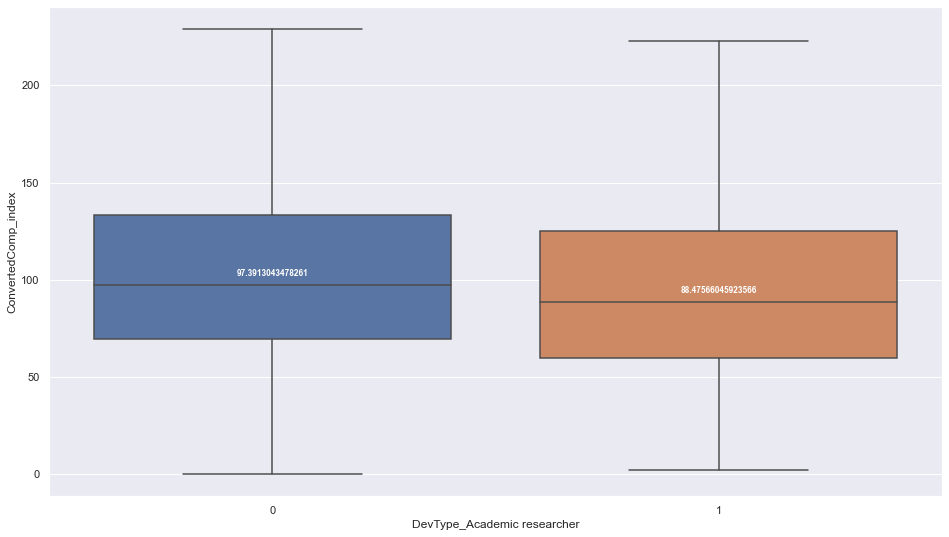

Leverage +/-: -0.07


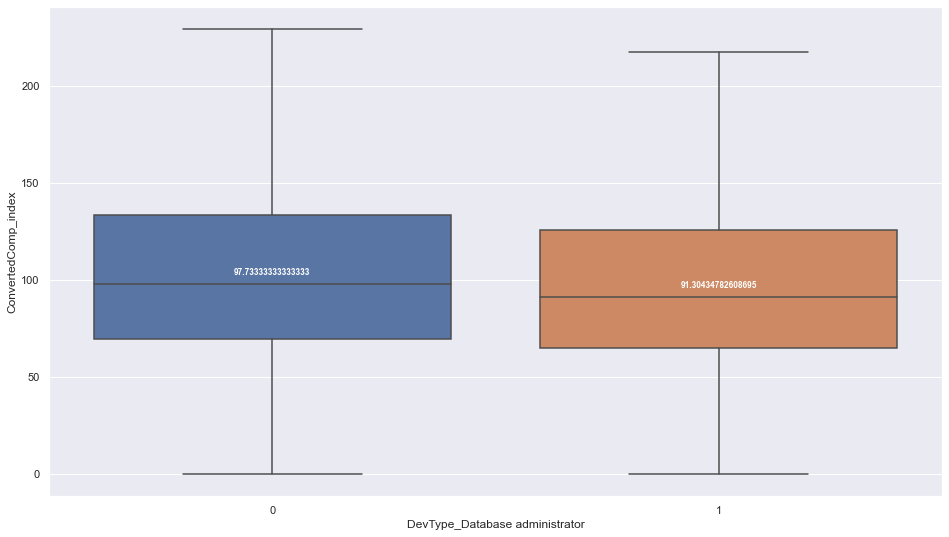

Leverage +/-: -0.15


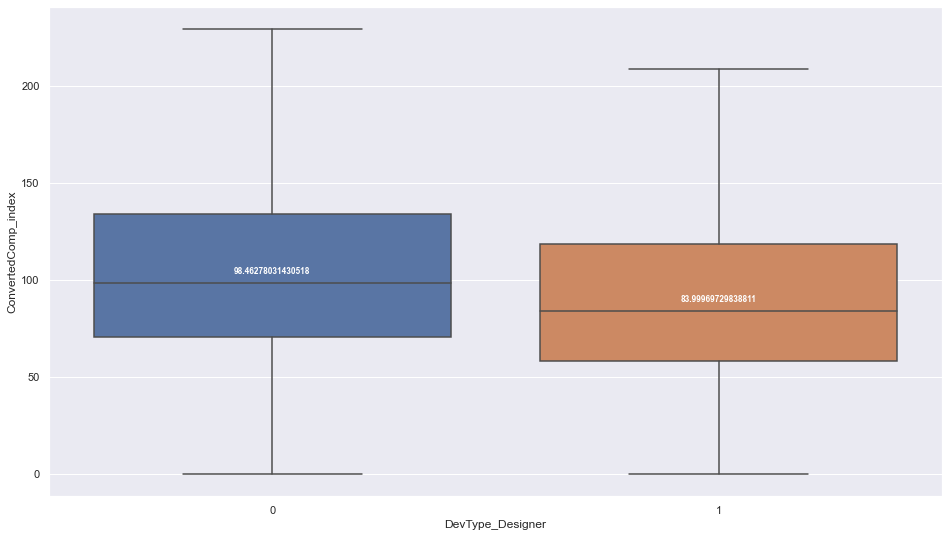

Leverage +/-: -0.06


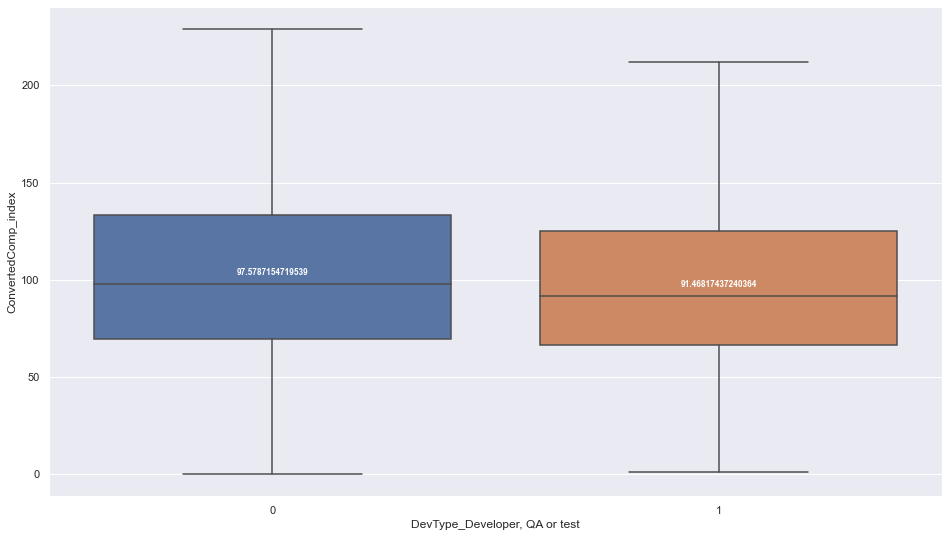

Leverage +/-: 0.11


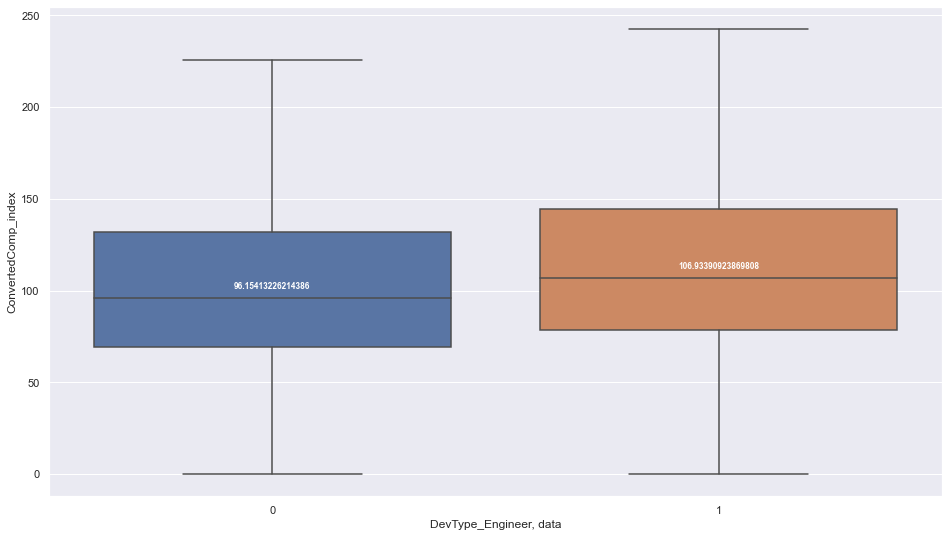

Leverage +/-: -0.02


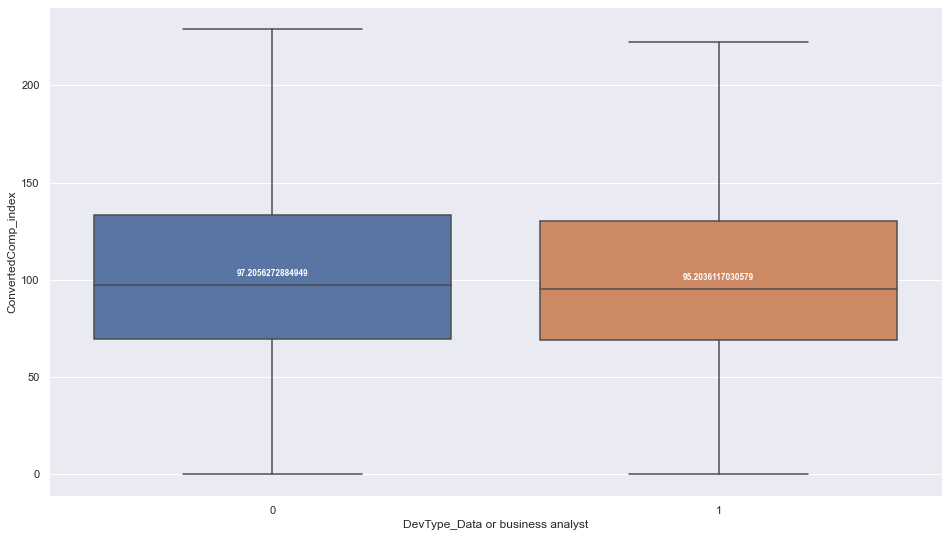

Leverage +/-: 0.14


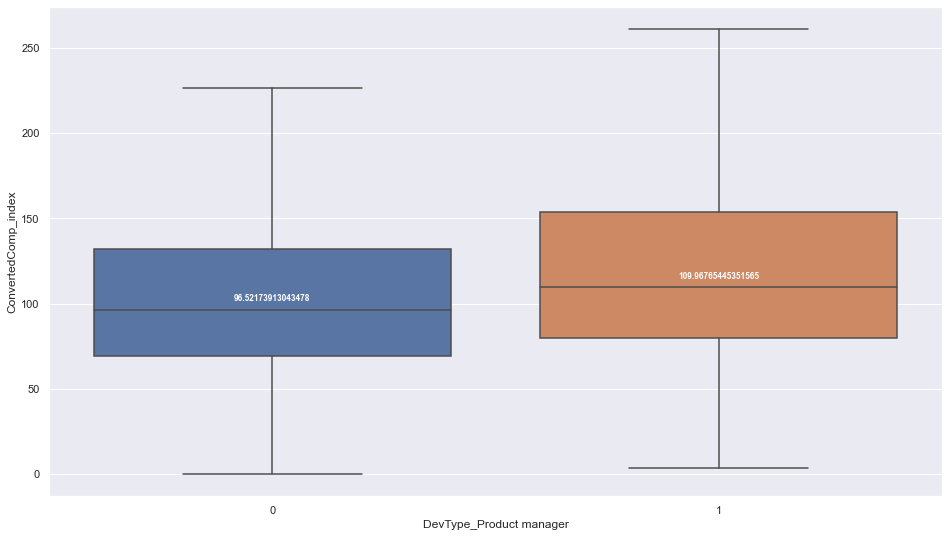

Leverage +/-: 0.07


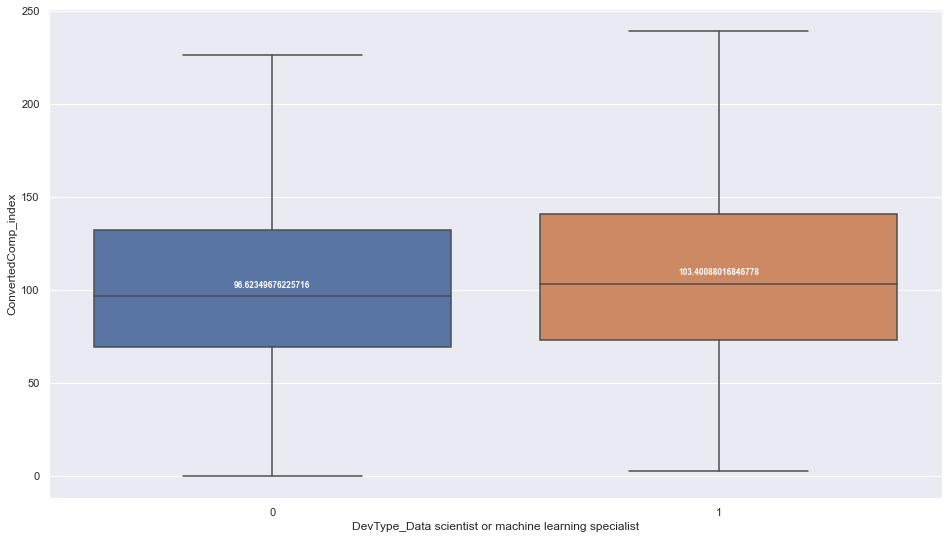

Leverage +/-: 0.03


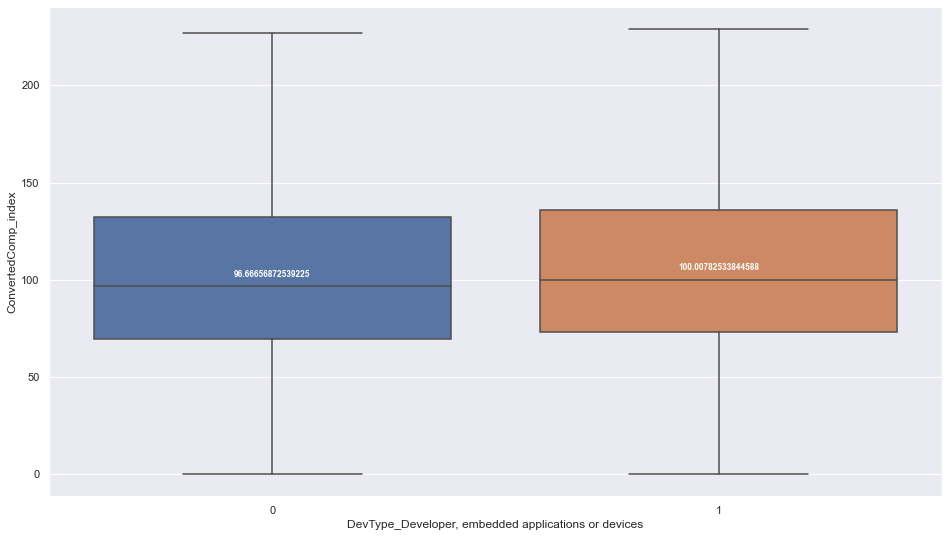

Leverage +/-: 0.16


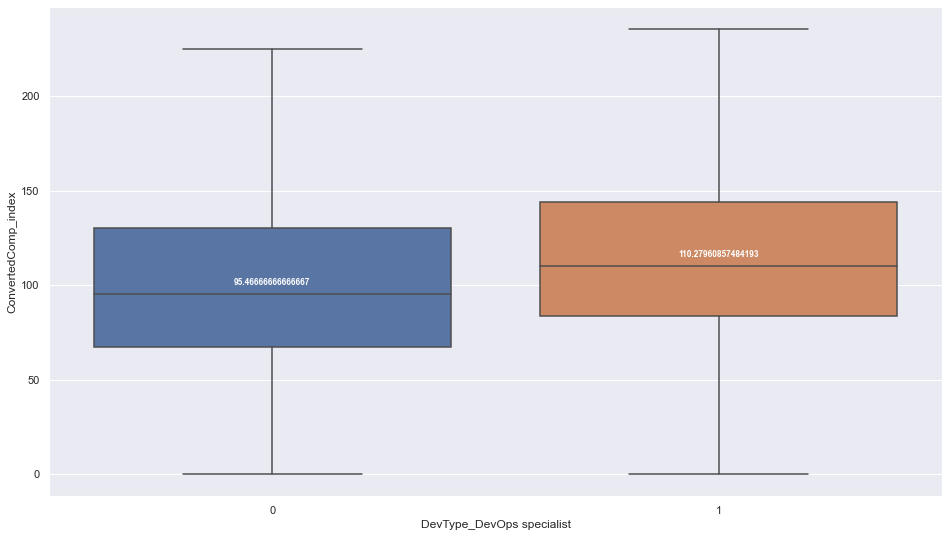

Leverage +/-: -0.03


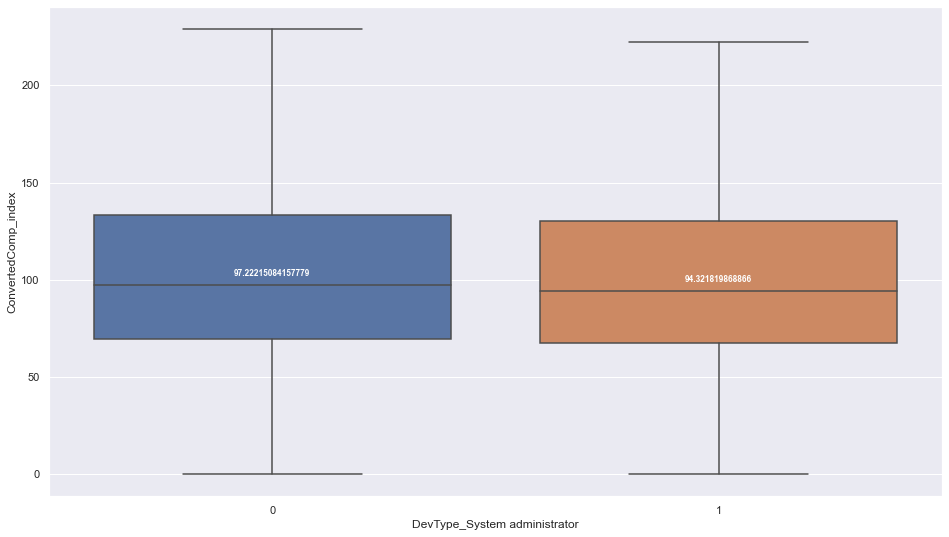

Leverage +/-: 0.43


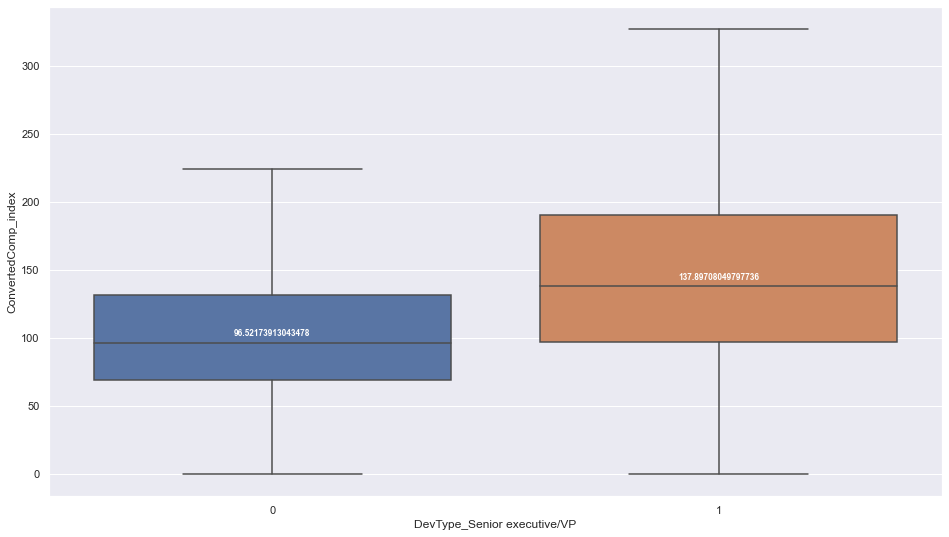

Leverage +/-: 0.27


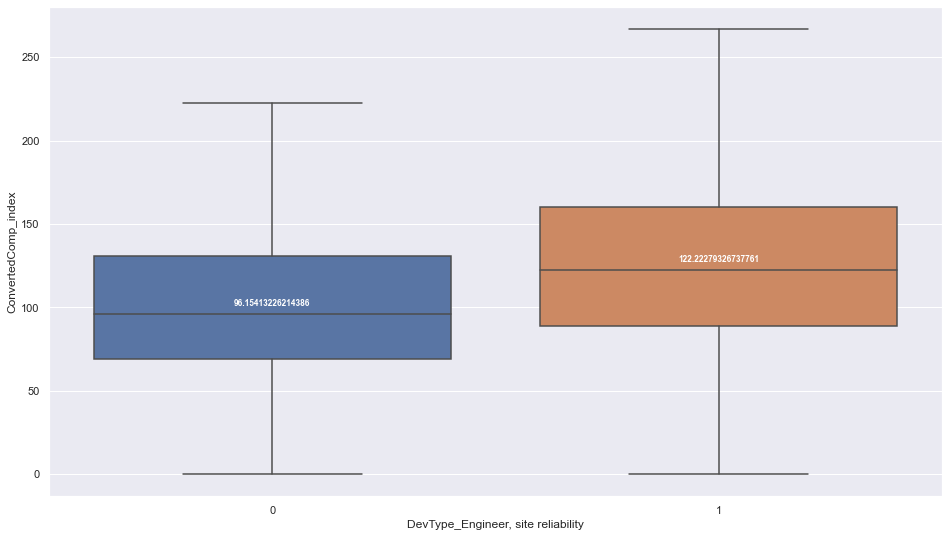

Leverage +/-: 0.43


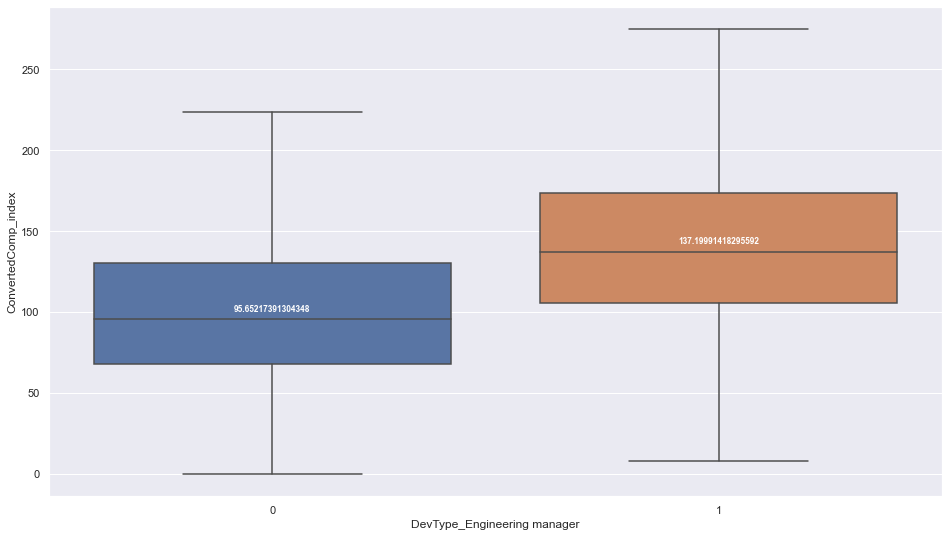

Leverage +/-: 0.03


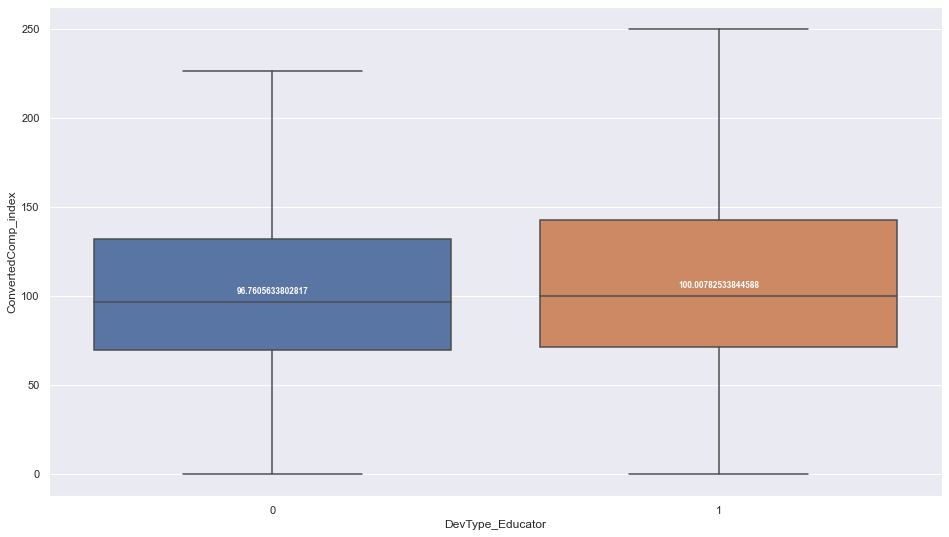

Leverage +/-: -0.16


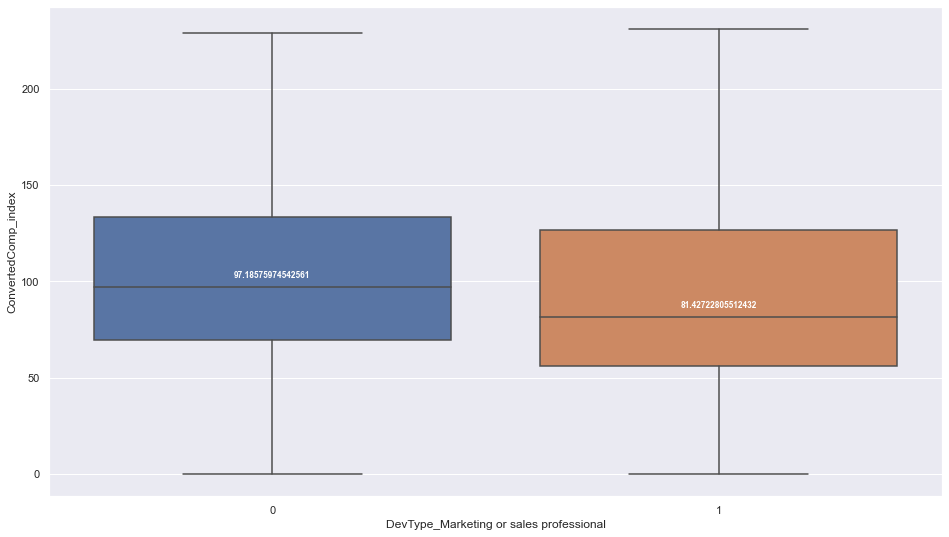

In [40]:
dev_type = [col for col in data.columns if "DevType_" in col]
data_ =  data[(data.MainBranch == "I am a developer by profession")
             &  (data.ConvertedComp <= 300000)]

for col in dev_type:
    ax = sns.boxplot(x=col, y="ConvertedComp_index", data=data_,
                     showfliers = False)
    
    medians = data_.groupby([col])['ConvertedComp_index'].median()
    vertical_offset = data_['ConvertedComp_index'].median() * 0.05 # offset from median for display
    print("Leverage +/-:", round(medians[1] / medians[0] -1,2))
    for xtick in ax.get_xticks():
        ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
                horizontalalignment='center',size='x-small',color='w',weight='semibold')
    
    plt.show()

### Technologies by DevType

In [31]:
technologies = [feat for feat in data.columns if "WorkedWith" in feat]
technologies

['DatabaseWorkedWith_Couchbase',
 'DatabaseWorkedWith_Microsoft SQL Server',
 'DatabaseWorkedWith_MySQL',
 'DatabaseWorkedWith_PostgreSQL',
 'DatabaseWorkedWith_DynamoDB',
 'DatabaseWorkedWith_Elasticsearch',
 'DatabaseWorkedWith_Firebase',
 'DatabaseWorkedWith_MariaDB',
 'DatabaseWorkedWith_SQLite',
 'DatabaseWorkedWith_MongoDB',
 'DatabaseWorkedWith_Oracle',
 'DatabaseWorkedWith_Redis',
 'DatabaseWorkedWith_IBM DB2',
 'DatabaseWorkedWith_Cassandra',
 'LanguageWorkedWith_Assembly',
 'LanguageWorkedWith_Bash/Shell/PowerShell',
 'LanguageWorkedWith_C',
 'LanguageWorkedWith_C#',
 'LanguageWorkedWith_C++',
 'LanguageWorkedWith_HTML/CSS',
 'LanguageWorkedWith_JavaScript',
 'LanguageWorkedWith_PHP',
 'LanguageWorkedWith_Python',
 'LanguageWorkedWith_SQL',
 'LanguageWorkedWith_TypeScript',
 'LanguageWorkedWith_VBA',
 'LanguageWorkedWith_R',
 'LanguageWorkedWith_Java',
 'LanguageWorkedWith_Kotlin',
 'LanguageWorkedWith_Scala',
 'LanguageWorkedWith_Swift',
 'LanguageWorkedWith_Ruby',
 'Languag

In [32]:
dev_types = [col for col in data.columns if "DevType_" in col]
dev_types

['DevType_Scientist',
 'DevType_Developer, back-end',
 'DevType_Developer, desktop or enterprise applications',
 'DevType_Developer, front-end',
 'DevType_Developer, full-stack',
 'DevType_Developer, game or graphics',
 'DevType_Developer, mobile',
 'DevType_Academic researcher',
 'DevType_Database administrator',
 'DevType_Designer',
 'DevType_Developer, QA or test',
 'DevType_Engineer, data',
 'DevType_Data or business analyst',
 'DevType_Product manager',
 'DevType_Data scientist or machine learning specialist',
 'DevType_Developer, embedded applications or devices',
 'DevType_DevOps specialist',
 'DevType_System administrator',
 'DevType_Senior executive/VP',
 'DevType_Engineer, site reliability',
 'DevType_Engineering manager',
 'DevType_Educator',
 'DevType_Marketing or sales professional']

In [34]:
usage_ratios = pd.DataFrame()
for dev_type in dev_types:
    dev_type_data = data[data[dev_type] == 1]
    for tech in technologies:
        counts = dev_type_data[tech].value_counts()    
        usage_ratio = counts[1] / counts.sum()
        usage_ratios = usage_ratios.append(pd.DataFrame.from_dict({"dev_type":[dev_type],
                                                                   "tech": [tech],
                                                                   "usage_ratio": [usage_ratio]}))
usage_ratios = usage_ratios.sort_values(by=["dev_type", "usage_ratio"], ascending=[True, False])
usage_ratios = usage_ratios[usage_ratios.usage_ratio >= 0.65]
usage_ratios.to_csv("../data/interim/tech_groups_by_dev_type.csv", sep="|", index=False)

In [35]:
relevant_tech = usage_ratios[usage_ratios.dev_type=="DevType_Developer, front-end"].tech.tolist()

In [ ]:
pd.read_csv("../data/interim/tech_groups_by_dev_type.csv", sep="|")